# Observation
    
## 1. Data Imbalance
training data: 569877(96.5%) v.s. 20663(3.5%)


#### 1.1 Try to balance the data:

##### (Over sampling)

1. simple over sampling 
2. SMOTE

##### (under sampling)
1. simple under sampling
2. Tomek links

#### 1.2 Transfer learning for rare label data

## 2. large class in category features

26 category features class<=10,  23 category features class>10 
(number of class, from 3 to 13553)


##### (if class>10, one hot encoding may suffer from dimension explode
##### choose other encoding methods if class>10 and dis-order features)

有序資料可以直接label encoding

無序資料通常做one hot encoding (ex. xgboost, 例外: LGBM餵label encoding即可)

## 3. plenty of NaN data
Around 180 features get over 50% NaN datas 

## 4. others
(weak) The fraud transaction of most fraud identities < 2, that is to say, most user may not fraud in the same device/place. (if the features in Identity.csv is independent with times)(if not considering NaN)



# To do to improve model performance

### 1. deal with data imbalancing (performance variance in current work, 80-90%)
origin data

(current) simple upsampling fraud data

SMOTE

### 2. change cross-validaiton method (for time series data)

basic cv

(current) time series cv

### 3. optimize PR curve instead of ROC (PR is a better choice for data imbalance task)

# Feedback of this project

### 1. important features:
1. card1
2. card2
3. TransactionID
4. TransactionAmt
5. addr1

### 2. interesting discovery:
1. famous email domain get higher fraud probability. ex. 'gmail.com' 'hotmail.com' 'outlook.com'
2. famous device get higher fraud probability. ex. 'Windows' 'iOS Device'


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import TimeSeriesSplit

import lightgbm as lgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
tr_id_path = '/kaggle/input/ieee-fraud-detection/train_identity.csv'
tr_tran_path = '/kaggle/input/ieee-fraud-detection/train_transaction.csv'
te_id_path = '/kaggle/input/ieee-fraud-detection/test_identity.csv'
te_tran_path = '/kaggle/input/ieee-fraud-detection/test_transaction.csv'

In [3]:
tr_id = pd.read_csv(tr_id_path)
tr_tran = pd.read_csv(tr_tran_path)
te_id = pd.read_csv(te_id_path)
te_tran = pd.read_csv(te_tran_path)

# Data Wrangling & Visualization

In [4]:
## align tr, te columns title

clean_te_id_columns = [("_").join(x.split('-')) for x in te_id.columns]
clean_te_id_columns_dict = dict(zip(te_id.columns, clean_te_id_columns))
te_id = te_id.rename(columns = clean_te_id_columns_dict, inplace=False)

In [5]:
print (tr_id.head)
print (tr_tran.head)

<bound method NDFrame.head of         TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  \
0             2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN   
1             2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN   
2             2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN   
3             2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN   
4             2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN   
...               ...    ...       ...    ...    ...    ...    ...    ...   
144228        3577521  -15.0  145955.0    0.0    0.0    0.0    0.0    NaN   
144229        3577526   -5.0  172059.0    NaN    NaN    1.0   -5.0    NaN   
144230        3577529  -20.0  632381.0    NaN    NaN   -1.0  -36.0    NaN   
144231        3577531   -5.0   55528.0    0.0    0.0    0.0   -7.0    NaN   
144232        3577534  -45.0  339406.0    NaN    NaN  -10.0 -100.0    NaN   

        id_08  id_09  ...                    

In [6]:
tr = pd.merge(tr_id, tr_tran, on=['TransactionID'], how='right')
tr.head(10)

te = pd.merge(te_id, te_tran, on=['TransactionID'], how='right')


In [7]:
## Find users

tr_id_columns = tr_id.columns

x = tr_id_columns.drop('TransactionID').tolist()
tr_id_unique_fraud = tr[tr['isFraud']==1].groupby(x).size().reset_index().rename(columns={0:'count'})
sorted_tr_id_unique_fraud = tr_id_unique_fraud.sort_values('count', ascending=False).reset_index(drop=True)
print (sorted_tr_id_unique_fraud)

del tr_id_unique_fraud, sorted_tr_id_unique_fraud

     id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  id_10  \
0    -25.0  112425.0    0.0    0.0   21.0 -100.0   13.0  -47.0    0.0    0.0   
1   -100.0   34021.0    0.0    0.0    5.0  -33.0   14.0  -33.0    0.0    0.0   
2    -25.0  436863.0    0.0    0.0    9.0  -32.0   42.0  -36.0    0.0    0.0   
3    -10.0  153184.0    0.0    0.0    3.0  -34.0   12.0  -33.0    0.0    0.0   
4    -10.0  152174.0    0.0    0.0    1.0  -33.0   21.0  -35.0    0.0    0.0   
..     ...       ...    ...    ...    ...    ...    ...    ...    ...    ...   
99   -25.0  108905.0    0.0    0.0    6.0  -32.0   40.0  -48.0    0.0    0.0   
100  -25.0   97793.0    0.0    0.0   15.0  -33.0   16.0 -100.0    0.0    0.0   
101  -25.0   50914.0    0.0    0.0   15.0  -53.0   26.0  -33.0    0.0    0.0   
102  -25.0   35674.0    0.0    0.0   10.0  -32.0   12.0  -30.0    0.0    0.0   
103   -5.0  275348.0    0.0    0.0   10.0  -35.0   16.0  -35.0    0.0    0.0   

     ...  id_32      id_33           id

In [8]:
del tr_tran,tr_id
del te_tran,te_id

clean data

In [9]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan) 
tr = clean_inf_nan(tr)
te = clean_inf_nan(te)

### Data imbalance

[569877  20663]
[96.50099909  3.49900091]
Suffer from data imbalancing


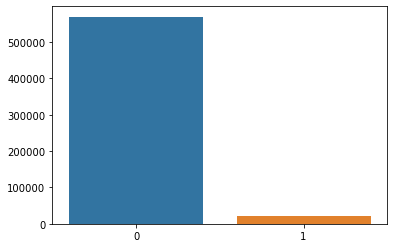

In [10]:
tr_label = tr['isFraud']

x = tr_label.value_counts().values
print (x)
print (x/sum(x)*100)
print ('Suffer from data imbalancing')
sns.barplot([0,1], x)

### Data augmentation

In [11]:
tr_not_fraud = tr[tr['isFraud']==0]
tr_fraud = tr[tr['isFraud']==1]

del tr

In [12]:
tr_fraud_up_sample = resample(tr_fraud,
                          replace=True, # sample with replacement
                          n_samples=len(tr_not_fraud), # match number in majority class
                          random_state=1) # reproducible results

del tr_fraud

In [13]:
tr = pd.concat([tr_not_fraud, tr_fraud_up_sample])

del tr_not_fraud, tr_fraud_up_sample

In [14]:
tr = tr.sort_values('TransactionID', ascending=True)

In [15]:
# seperate features and label
tr_label = tr['isFraud']
tr.drop(columns=["isFraud"], inplace=True)
tr.head(2) 

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### category feature processing (large class in category features)

id_12 3 
id_13 56 
id_14 29 
id_15 4 
id_16 3 
id_17 128 
id_18 20 
id_19 569 
id_20 548 
id_21 735 
id_22 36 
id_23 4 
id_24 18 
id_25 441 
id_26 116 
id_27 3 
id_28 3 
id_29 3 
id_30 88 
id_31 173 
id_32 7 
id_33 462 
id_34 5 
id_35 3 
id_36 3 
id_37 3 
id_38 3 
DeviceType 3 
DeviceInfo 2800 
ProductCD 5 
card4 5 
card6 5 
M4 4 
P_emaildomain 61 
R_emaildomain 61 
card1 17091 
card2 502 
card3 134 
card5 139 
addr1 442 
addr2 94 
M1 3 
M2 3 
M3 3 
M5 3 
M6 3 
M7 3 
M8 3 
M9 3 


Text(0.5, 1.0, 'Distribution of category features class')

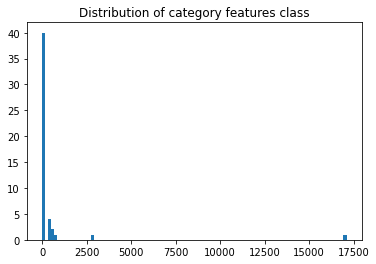

In [16]:
category_cols=['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

len_class_list = []
label_encoder={}
top_important_features=['card1', 'card2', 'addr1', 'P_emaildomain', 'id_20', 'id_19', 'DeviceInfo']  ## from results below
for col in category_cols:
    if col in tr.columns:
        le=LabelEncoder()
        le.fit(list(tr[col].astype(str).values) + list(te[col].astype(str).values))
        print (str(col) + ' ' + str(len(le.classes_))+ ' ')
        tr[col] = le.transform(list(tr[col].astype(str).values))
        te[col] = le.transform(list(te[col].astype(str).values))

        len_class_list.append(len(le.classes_))
        
        if col in top_important_features:
            label_encoder[col] = le

plt.hist(len_class_list, bins=100)
plt.title('Distribution of category features class')

In [17]:
print (f'There are {len(len_class_list)} category label' )
print ( f'{len([x for x in len_class_list if x>10])} category label, class >10')
print ( f'{len([x for x in len_class_list if x<=10])} category label, class <=10')

There are 49 category label
23 category label, class >10
26 category label, class <=10


### nan processing

Text(0.5, 1.0, 'Distribution of features nan_ratio')

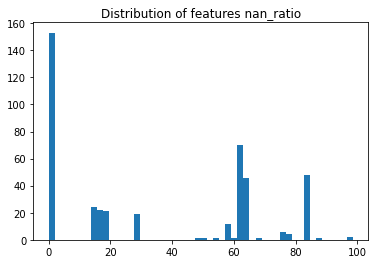

In [19]:
nan_ratio = (tr.isna().sum())/len(tr)*100
plt.hist(nan_ratio, bins=50)
plt.title('Distribution of features nan_ratio')

In [20]:
def exclude_features_with_nan_ratio(df, nan_ratio, threshold=50):
    features_column = nan_ratio[nan_ratio.values<threshold].index
    return df[features_column]

def fill_nan_with_mean(df, numerical_columns):
    df[numerical_columns].fillna(df[numerical_columns].mean())
    return df.fillna(df.mean())

numerical_cols = [x for x in tr.columns if x not in category_cols]

tr = exclude_features_with_nan_ratio(tr, nan_ratio)
# tr = fill_nan_with_mean(tr, numerical_cols)

tr.head(10)

te = exclude_features_with_nan_ratio(te, nan_ratio)

In [21]:
def z_score_normalize(df):
    return (df-df.mean())/df.std()
# norm_tr = z_score_normalize(tr)

In [22]:
# pca=PCA(n_components=2)
# pca.fit(norm_tr)
# pca_result = pca.transform(norm_tr)
# plt.scatter(pca_result[:,0], pca_result[:,1], c=tr_label, s=20, alpha=1, marker='o')
# plt.show()

# pca=PCA(n_components=2)
# pca.fit(norm_tr[numerical_cols])
# pca_result = pca.transform(norm_tr[numerical_cols])
# plt.scatter(pca_result[:,0], pca_result[:,1], c=tr_label, s=20, alpha=1, marker='o')
# plt.show()

# pca=PCA(n_components=2)
# pca.fit(norm_tr[category_cols])
# pca_result = pca.transform(norm_tr[category_cols])
# plt.scatter(pca_result[:,0], pca_result[:,1], c=tr_label, s=20, alpha=1, marker='o')
# plt.show()

In [23]:
# tsne = TSNE(n_components=2)
# tsne.fit(norm_tr)
# tsne_result = tsne.transform(norm_tr)
# tsne.scatter(tsne_result[:,0], tsne_result[:,1], c=tr_label, s=20, alpha=1, marker='o')
# plt.show()

# Modeling

In [24]:
# train_x, val_x, train_y, val_y = train_test_split(tr, tr_label, test_size=0.2, random_state=7)

# del tr, tr_label

In [25]:
params = {'num_leaves': [256],
          'min_child_samples': [79],
          'max_depth': [13],
          'learning_rate': [0.03],
          "subsample_freq": [3],
          "subsample": [0.9],
          "bagging_seed": [11],
          "verbosity": [-1],
          'reg_alpha': [0.3],
          'reg_lambda': [0.3],
          'colsample_bytree': [0.9]
         }

lgbm_classifier = lgb.LGBMClassifier(
          objective= 'binary',
          boosting_type= "gbdt",
          metric= 'auc'
)

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(lgbm_classifier, n_jobs=1, param_grid=params, cv = tscv, scoring="roc_auc", verbose=10)
gsearch.fit(tr, tr_label)

best_paramters = gsearch.best_estimator_.get_params()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.858, total=  26.5s
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.5s remaining:    0.0s


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.902, total=  50.2s
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.889, total= 1.2min
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.909, total= 1.6min
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.1min remaining:    0.0s


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.913, total= 2.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished


In [26]:
gsearch.cv_results_

{'mean_fit_time': array([72.23003364]),
 'std_fit_time': array([33.51482508]),
 'mean_score_time': array([1.39990301]),
 'std_score_time': array([0.0906483]),
 'param_bagging_seed': masked_array(data=[11],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_colsample_bytree': masked_array(data=[0.9],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.03],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[13],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_samples': masked_array(data=[79],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_num_leaves': masked_array(data=[256],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_reg_alpha': masked_array(data=[0.3],
              mask=[False

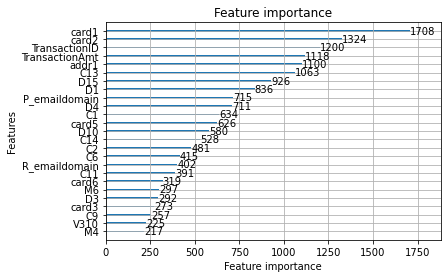

In [27]:
lgb.plot_importance(gsearch.best_estimator_, max_num_features=25)

In [28]:
pred_te = gsearch.best_estimator_.predict(te)

In [29]:
submit_df = pd.DataFrame(data={'TransactionID': te['TransactionID'], 'isFraud': pred_te})
submit_df.to_csv('/kaggle/working/submission_us_tcv.csv', index=False)

# Feedback

In [30]:
tr_non_fraud = tr[tr_label==0]
tr_fraud = tr[tr_label==1]

In [68]:
def plot_distribution(feature, tr_non_fraud, tr_fraud, label_encoder=None, up_sampling=True):
    non_fraud = tr_non_fraud[feature]
    fraud = tr_fraud[feature]
    
    if label_encoder:
        non_fraud= label_encoder.inverse_transform(non_fraud)
        fraud = label_encoder.inverse_transform(fraud)
        
        non_fraud = np.array([x for x in non_fraud if x !='nan']).astype(float)
        fraud = np.array([x for x in fraud if x !='nan']).astype(float)
    
    if up_sampling:
        fraud = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(non_fraud), # match number in majority class
                          random_state=1) # reproducible results
    
    
    plt.hist(non_fraud, bins=50)
    plt.title(f'Distribution of non_fraud {feature}')
    plt.hist(fraud, bins=50)
    plt.title(f'Distribution of fraud {feature}')
    plt.show()
    

    ax1=sns.kdeplot(non_fraud,shade=True,label='non_fraud')
    ax2=sns.kdeplot(fraud,shade=True,label='fraud')
    plt.show()

    print (f'Non_fraud, mean:{np.mean(non_fraud)}, std:{np.std(non_fraud)}')
    print (f'fraud, mean:{np.mean(fraud)}, std:{np.std(fraud)}')

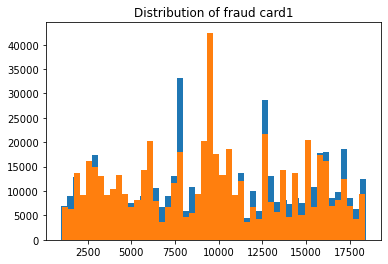

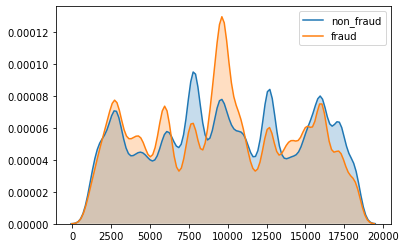

Non_fraud, mean:9911.464380910267, std:4905.668065792617
fraud, mean:9553.425714671763, std:4757.139868954806


In [32]:
plot_distribution('card1', tr_non_fraud, tr_fraud, label_encoder=label_encoder['card1'])

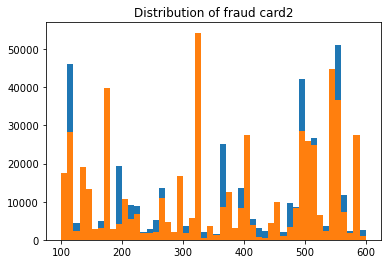

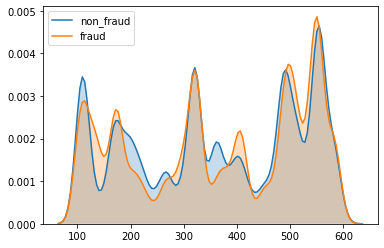

Non_fraud, mean:362.4539810854575, std:157.72592439792524
fraud, mean:365.40161783645993, std:159.70733857467926


In [33]:
plot_distribution('card2', tr_non_fraud, tr_fraud, label_encoder=label_encoder['card2'])

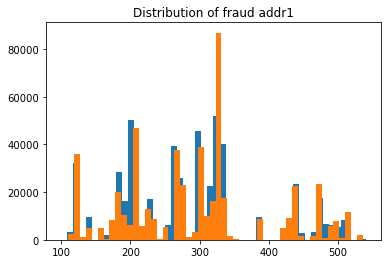

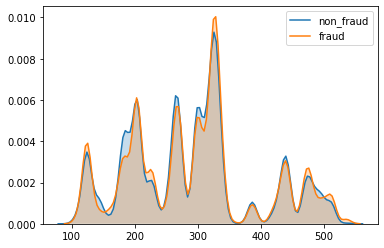

Non_fraud, mean:290.6433410429918, std:101.69246447398687
fraud, mean:294.35070090171746, std:103.70448210742009


In [34]:
plot_distribution('addr1', tr_non_fraud, tr_fraud, label_encoder=label_encoder['addr1'])

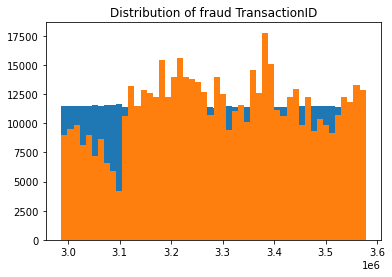

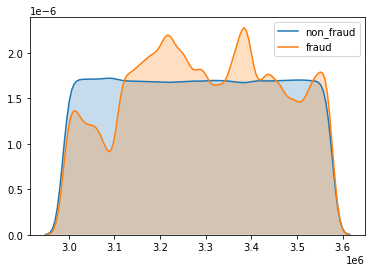

Non_fraud, mean:3281809.6617550803, std:170754.6311082149
fraud, mean:3294935.9249153766, std:161847.33065435488


In [35]:
plot_distribution('TransactionID', tr_non_fraud, tr_fraud)

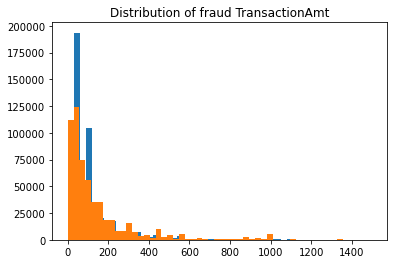

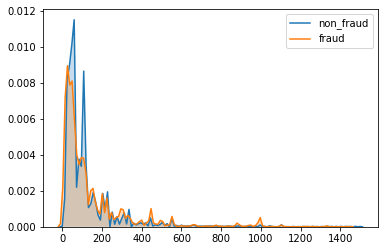

Non_fraud, mean:120.97806767252548, std:153.84540200533428
fraud, mean:141.04740821401813, std:186.5814536790674


In [36]:
# filt high TransactionAmt
filt_tr_non_fraud = tr_non_fraud[tr_non_fraud['TransactionAmt']<1500]
filt_tr_fraud = tr_fraud[tr_fraud['TransactionAmt']<1500]

plot_distribution('TransactionAmt', filt_tr_non_fraud, filt_tr_fraud)

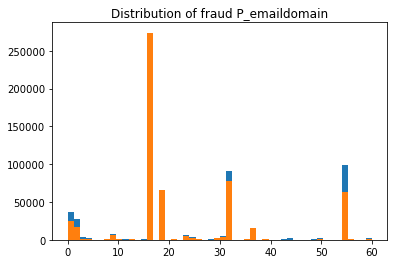

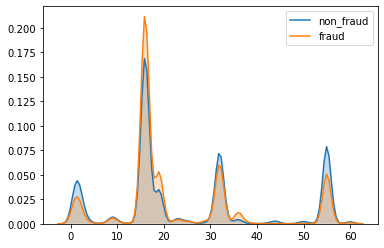

Non_fraud, mean:24.929498821675555, std:16.93455049628202
fraud, mean:22.741795159306307, std:14.18001914114254
{0: 1129, 1: 23481, 2: 16775, 3: 832, 4: 1469, 5: 78, 8: 632, 9: 6868, 10: 831, 11: 293, 12: 248, 13: 217, 14: 132, 15: 304, 16: 274181, 19: 65931, 21: 565, 23: 5402, 24: 166, 25: 2328, 26: 1126, 28: 395, 29: 2959, 30: 721, 31: 2476, 32: 77365, 34: 28, 35: 451, 36: 13240, 37: 1608, 38: 24, 39: 858, 42: 95, 43: 56, 44: 327, 45: 30, 48: 92, 50: 568, 55: 63596, 56: 430, 58: 57, 59: 137, 60: 1376}
['gmail.com' 'hotmail.com' 'outlook.com']


In [37]:
plot_distribution('P_emaildomain', tr_non_fraud, tr_fraud)

fraud_mail = tr_fraud['P_emaildomain']
unique, counts = np.unique(fraud_mail, return_counts=True)
print (dict(zip(unique, counts )))
print (label_encoder['P_emaildomain'].inverse_transform([16,19,36]))

# Challenge: Can the model predict with user information only?

In [38]:
tr_id_columns = [ x for x in tr_id_columns if x in tr.columns]
tr = tr[tr_id_columns]

In [39]:
params = {'num_leaves': [256],
          'min_child_samples': [79],
          'max_depth': [13],
          'learning_rate': [0.03],
          "subsample_freq": [3],
          "subsample": [0.9],
          "bagging_seed": [11],
          "verbosity": [-1],
          'reg_alpha': [0.3],
          'reg_lambda': [0.3],
          'colsample_bytree': [0.9]
         }

lgbm_classifier = lgb.LGBMClassifier(
          objective= 'binary',
          boosting_type= "gbdt",
          metric= 'auc'
)

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(lgbm_classifier, n_jobs=1, param_grid=params, cv = tscv, scoring="roc_auc", verbose=10)
gsearch.fit(tr, tr_label)

best_paramters = gsearch.best_estimator_.get_params()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.440, total=   5.0s
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.553, total=   8.9s
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.631, total=  12.0s
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.9s remaining:    0.0s


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.690, total=  15.5s
[CV] bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   41.4s remaining:    0.0s


[CV]  bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03, max_depth=13, min_child_samples=79, num_leaves=256, reg_alpha=0.3, reg_lambda=0.3, subsample=0.9, subsample_freq=3, verbosity=-1, score=0.635, total=  19.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


In [40]:
gsearch.cv_results_

{'mean_fit_time': array([11.66247077]),
 'std_fit_time': array([5.12777148]),
 'mean_score_time': array([0.57231727]),
 'std_score_time': array([0.01836161]),
 'param_bagging_seed': masked_array(data=[11],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_colsample_bytree': masked_array(data=[0.9],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.03],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[13],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_samples': masked_array(data=[79],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_num_leaves': masked_array(data=[256],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_reg_alpha': masked_array(data=[0.3],
              mask=[False

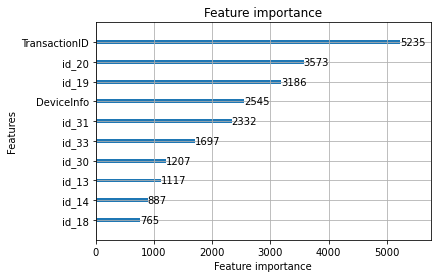

In [41]:
lgb.plot_importance(gsearch.best_estimator_, max_num_features=10)

In [42]:
tr_non_fraud = tr[tr_label==0]
tr_fraud = tr[tr_label==1]

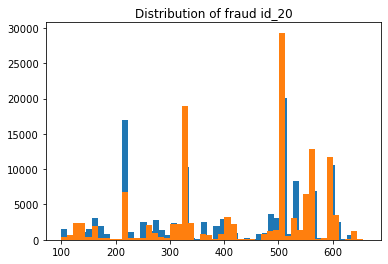

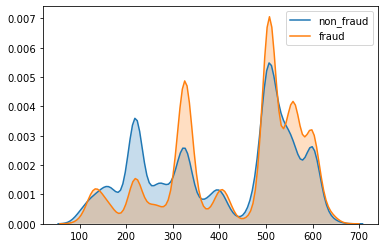

Non_fraud, mean:401.1337050612181, std:152.8255309565895
fraud, mean:435.50989628012167, std:140.67026129355355


In [44]:
plot_distribution('id_20', tr_non_fraud, tr_fraud, label_encoder=label_encoder['id_20'])

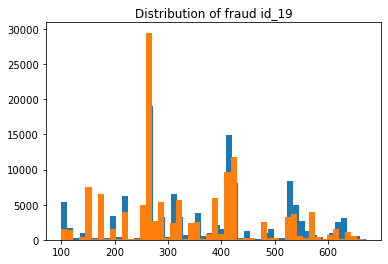

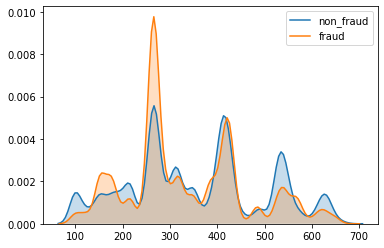

Non_fraud, mean:354.85495010913627, std:142.17839879863783
fraud, mean:333.1550748362956, std:126.23209577053477


In [46]:
plot_distribution('id_19', tr_non_fraud, tr_fraud, label_encoder=label_encoder['id_19'])

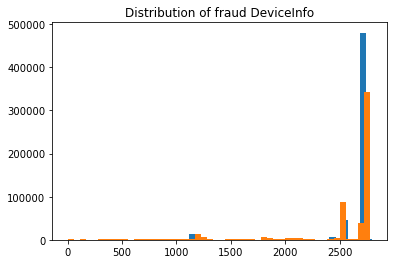

Non_fraud, mean:2632.139468692367, std:363.6347740611813
fraud, mean:2478.146299991051, std:558.6308430044852
{2: 65, 13: 32, 21: 23, 24: 177, 27: 87, 29: 162, 31: 227, 34: 310, 44: 159, 52: 76, 62: 46, 72: 53, 84: 31, 92: 89, 111: 65, 112: 26, 116: 218, 125: 23, 131: 21, 141: 844, 143: 82, 209: 157, 211: 99, 218: 60, 223: 82, 274: 82, 279: 115, 283: 638, 285: 249, 290: 78, 309: 17, 313: 27, 314: 621, 316: 233, 317: 326, 318: 76, 322: 24, 325: 218, 329: 98, 331: 101, 339: 35, 345: 665, 349: 833, 368: 1346, 404: 92, 406: 25, 407: 115, 411: 140, 415: 115, 419: 20, 423: 54, 431: 280, 441: 39, 467: 102, 471: 82, 475: 391, 479: 627, 480: 734, 491: 159, 505: 257, 510: 84, 518: 64, 520: 321, 537: 127, 541: 21, 555: 110, 562: 529, 565: 32, 601: 36, 623: 596, 627: 94, 629: 161, 636: 28, 637: 39, 656: 99, 661: 196, 663: 287, 668: 194, 670: 20, 672: 349, 675: 441, 679: 136, 680: 78, 681: 82, 687: 82, 692: 182, 700: 887, 705: 177, 718: 63, 727: 136, 731: 199, 760: 37, 762: 67, 764: 1468, 798: 1654

In [67]:
plot_distribution('DeviceInfo', tr_non_fraud, tr_fraud)

fraud_device = tr_fraud['DeviceInfo']
unique, counts = np.unique(fraud_device, return_counts=True)
print (dict(zip(unique, counts )))
print (label_encoder['DeviceInfo'].inverse_transform([2526, 2693]))